In [42]:
import pandas as pd
import numpy as np
import math,os,sys

import seaborn as sns
import matplotlib.pyplot as plt

from functools import partial
from utils import efx_utils

sns.set_style(style= 'darkgrid')
sns.set_context("notebook")
%matplotlib inline
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [43]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score

In [44]:
res = efx_utils._load_all()
FEAT = res["FINAL_FEAT"]
# FEAT.remove("HAS_DEFAULT")
X = res["X"][FEAT]
y = res['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

files being loaded are :  ['FINAL_FEAT.pkl', 'FINAL_FEAT_V2.pkl', 'X.pkl', 'y.pkl']


In [45]:
len(FEAT)

51

In [46]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [ 90, 100, 110]#[int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [47]:
# random_grid

{'n_estimators': [200, 650, 1100, 1550, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True]}

In [48]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestClassifier()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train, y_train)

In [49]:
# print(rf_random.best_params_, "\n", rf_random.best_score_)
# {'n_estimators': 1550, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True} 
#  0.79275

In [50]:
best_param = {'n_estimators': 1550, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True} 
rf_classifier = RandomForestClassifier(**best_param)
rf_classifier.fit(X_train,y_train)

RandomForestClassifier(max_depth=90, max_features='sqrt', min_samples_leaf=4,
                       n_estimators=1550)

In [57]:
y_pred = rf_classifier.predict(X_test)
accuracy_score(y_test, y_pred)
print(f"The accuracy of the model is {round(accuracy_score(y_test,y_pred),3)*100} %")

The accuracy of the model is 79.2 %


In [52]:
# older version : The accuracy of the model is 79.0 %
# Train ROC AUC Score: 0.7720524065786656
# Test ROC AUC  Score: 0.7396785168239487

In [53]:
train_probs = rf_classifier.predict_proba(X_train)[:,1] 
probs = rf_classifier.predict_proba(X_test)[:, 1]
train_predictions = rf_classifier.predict(X_train)

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')

Train ROC AUC Score: 0.8657914305577701
Test ROC AUC  Score: 0.7405107924098917


In [54]:
pd.DataFrame({"Features":X_train.columns.values, "importance": rf_classifier.feature_importances_}).sort_values("importance",ascending=False).head()

,Features,importance
39,TOT_DEFAULT_>2,0.164819
36,HAS_DEFAULT,0.153909
37,TOT_DEFAULT_0,0.141997
4,LIMIT_BAL_<=50000.0,0.026049
22,LIMIT_BAL_>240000.0,0.020737


<AxesSubplot:>

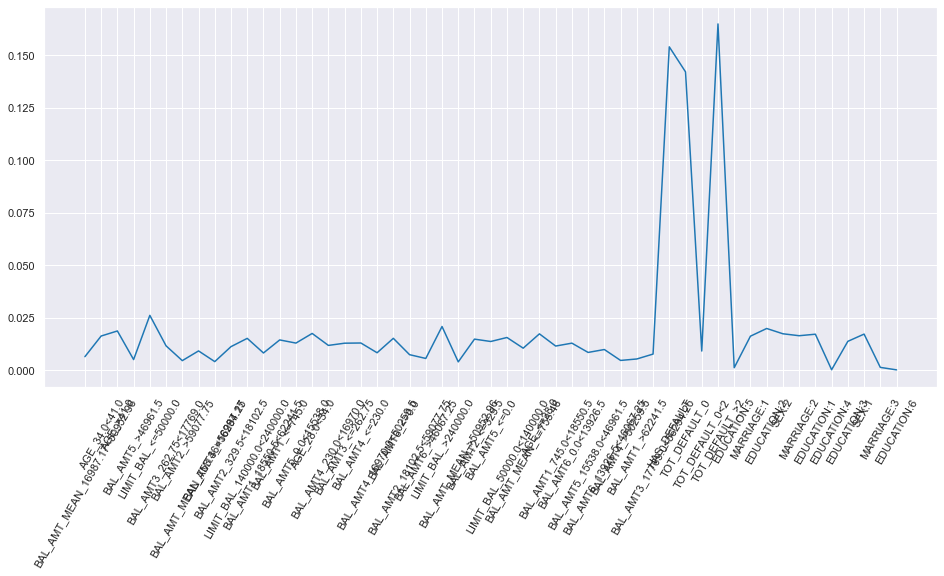

In [55]:
fig,ax = plt.subplots(figsize=(16, 7))
plt.xticks(rotation=60)
sns.lineplot(x = X_train.columns.values, y = rf_classifier.feature_importances_)

Recall Baseline: 1.0 Test: 0.3  Train: 0.39
Precision Baseline: 0.22 Test: 0.55  Train: 0.69
Roc Baseline: 0.5 Test: 0.74  Train: 0.87


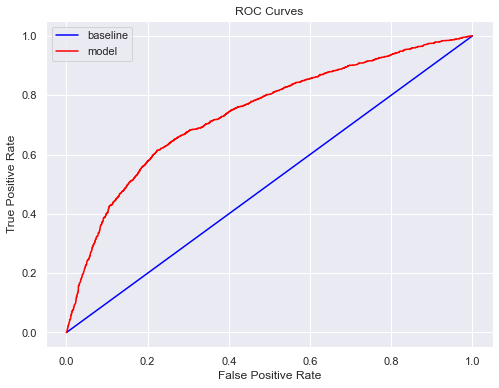

In [56]:
def evaluate_model(y_pred, probs,train_predictions, train_probs):
    baseline = {}
    baseline['recall']=recall_score(y_test,
                    [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test,
                    [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    results = {}
    results['recall'] = recall_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred)
    results['roc'] = roc_auc_score(y_test, probs)
    train_results = {}
    train_results['recall'] = recall_score(y_train,       train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    for metric in ['recall', 'precision', 'roc']:  
          print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)}  Train: {round(train_results[metric], 2)}')
     # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

evaluate_model(y_pred,probs,train_predictions,train_probs)